In [79]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [57]:
dataset_path = "./dataset"
classes = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

In [59]:
# Load dataset
images = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        # Skip non-image files
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            continue
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))  # Resize images to 128x128
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(class_idx)

In [60]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [61]:
# Convert to numpy arrays
images = np.array(images) / 255.0 
labels = np.array(labels)

In [62]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")

Training data: (364, 128, 128, 3), Validation data: (78, 128, 128, 3), Test data: (78, 128, 128, 3)


In [67]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

In [69]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,574 (24.86 MB)

 Trainable params: 6,517,574 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.2057 - loss: 1.7681 - val_accuracy: 0.2179 - val_loss: 1.6057
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.3518 - loss: 1.6236 - val_accuracy: 0.4103 - val_loss: 1.4524
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4589 - loss: 1.4643 - val_accuracy: 0.5000 - val_loss: 1.3025
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.5803 - loss: 1.2100 - val_accuracy: 0.5769 - val_loss: 1.0787
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.6562 - loss: 1.0468 - val_accuracy: 0.5897 - val_loss: 0.9237
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.6942 - loss: 0.9315 - val_accuracy: 0.7051 - val_loss: 0.7995
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.7347 - loss: 0.9013 - val_accuracy: 0.8462 - val_loss: 0.6342
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.7948 - loss: 0.7186 - val_accuracy: 0.

In [74]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9716 - loss: 0.0671
Test Accuracy: 0.97


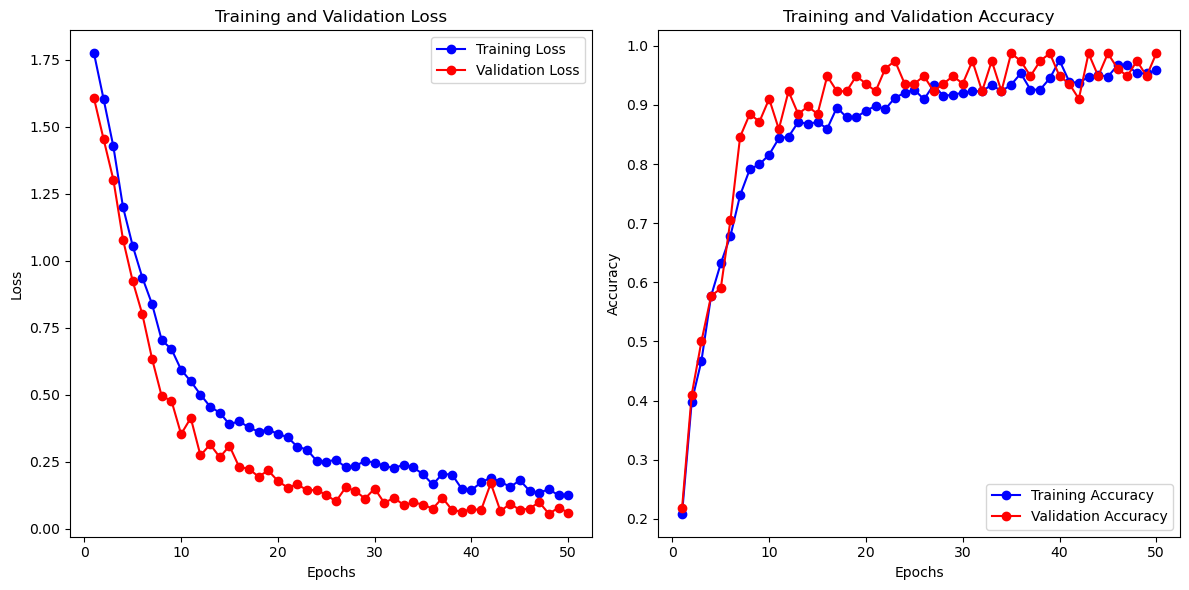

In [81]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()